In [1]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from ortools.linear_solver import pywraplp

from nsopy.methods.universal import UniversalPGM, UniversalDGM, UniversalFGM
from nsopy.methods.subgradient import SubgradientMethod
from nsopy.loggers import GenericDualMethodLogger

np.random.seed(102)
%matplotlib notebook

## 1. Low dimensional example
We consider the following optimization problem:

$$
\begin{array}{ll}
\min\limits_x     & -\frac{1}{2} x_1 - x_2 + x_3\\
\mathrm{s.t.}    & \frac{1}{2} x_1 + \frac{1}{2} x_2 + x_3 \geq 1\\
& x_1 + x_2 \leq 1\\
& 0 \leq x_1,x_2,x_3 \leq 1\\
& x_1 \in \left\{0,1\right\}.
\end{array}
$$

One can verify that the (unique) optimizer for this problem is $x^\star = [0, 1, 1]$.

We treat

$$
\frac{1}{2} x_1 + \frac{1}{2} x_2 + x_3 \geq 1\\
x_1 + x_2 \leq 1
$$
as the complicating constraints. 

Then the problem in the dual function **reduces to optimizing over the unit cube**:

$$
\begin{array}{lcll}
d(\lambda) & = & \min\limits_x & -\frac{1}{2} x_1 - x_2 + x_3 + \lambda_1 (1 - \frac{1}{2} x_1 - \frac{1}{2} x_2 - x_3) + \lambda_2(x_1+x_2 -1)\\
&& \mathrm{s.t.} & 0 \leq x_1,x_2,x_3 \leq 1\\
&&& x_1 \in \left\{0,1\right\}. \\
\end{array}
$$

This can be solved trivially:
* pick $x_i = 1$ if its objective is $\leq 0$, otherwise $x_i = 0$

In [2]:
class AnalyticalExample(object):
    def __init__(self):
        self.dimension = 2

    def oracle(self, lambda_k):
        assert type(lambda_k) == np.ndarray, 'WARNING: lambda_k should be a numpy array.'
        c = np.zeros(3, dtype=float)
        x_k = np.zeros(3, dtype=float)

        c[0] = - 0.5 - 0.5*lambda_k[0] + lambda_k[1]
        c[1] = - 1 - 0.5*lambda_k[0] + lambda_k[1]
        c[2] = + 1 - lambda_k[0]

        x_k[0] = 1 if c[0] < 0 else 0
        x_k[1] = 1 if c[1] < 0 else 0
        x_k[2] = 1 if c[2] < 0 else 0

        diff_d_k = np.zeros(2)
        diff_d_k[0] = 1 - 0.5*x_k[0] - 0.5*x_k[1] - x_k[2]
        diff_d_k[1] = x_k[0] + x_k[1] -1

        d_k = c[0]*x_k[0] + c[1]*x_k[1] + c[2] *x_k[2] + lambda_k[0] - lambda_k[1]

        return x_k, d_k, diff_d_k

    def projection_function(self, lambda_k):
        # initial point lambda_0
        if isinstance(lambda_k, int) and lambda_k == 0:
            return np.zeros(self.dimension)
        
        # project lambda_k on the positive orthant
        return np.maximum(lambda_k, 0)

Set up entities:

In [3]:
problem = AnalyticalExample()
optimizer = UniversalPGM(problem.oracle, problem.projection_function, epsilon=0.01)
logger = GenericDualMethodLogger(optimizer)

Solve:

In [4]:
for iteration in range(60):
    optimizer.dual_step()

Plot the trajectory in dual space:

<IPython.core.display.Javascript object>


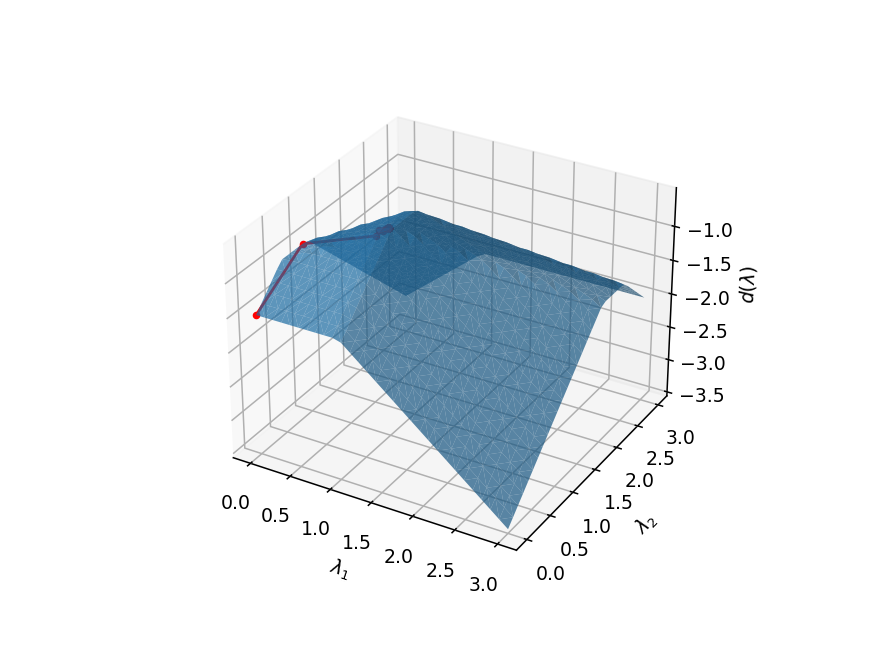

Text(0.5, 0, '$d(\\lambda)$')

In [5]:
box = np.linspace(0, 3, 30)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.plot_trisurf(np.array([lmd_1 for lmd_1 in box for lmd_2 in box]),
                np.array([lmd_2 for lmd_1 in box for lmd_2 in box]),
                np.array([problem.oracle(np.array([lmd_1, lmd_2]))[1] for lmd_1 in box for lmd_2 in box]),
                alpha=0.7)

plt.plot([lmd[0] for lmd in logger.lambda_k_iterates],
         [lmd[1] for lmd in logger.lambda_k_iterates],
         [d_lmd for d_lmd in logger.d_k_iterates], 'r.-')

ax.set_xlabel('$\lambda_1$')
ax.set_ylabel('$\lambda_2$')
ax.set_zlabel('$d(\lambda)$')

We can inspect the last dual iterates (solutions to the dual problem)

In [6]:
logger.lambda_k_iterates[-5:]

[array([1.00852273, 1.00852273]),
 array([0.99431818, 1.00852273]),
 array([1.00852273, 1.00852273]),
 array([0.99431818, 1.00852273]),
 array([1.00852273, 1.00852273])]

And the last **primal iterates** (approximate solutions):

In [7]:
logger.x_k_iterates[-5:]

[array([0., 1., 1.]),
 array([0., 1., 0.]),
 array([0., 1., 1.]),
 array([0., 1., 0.]),
 array([0., 1., 1.])]

## 2. Optimal Load Shedding

We consider the following optimization problem:

$$
\begin{array}{ll}
\min\limits_{x,y}     & \sum_{i} R_i \cdot x_i + \sum_{i,j} P_{i,j} \cdot y_{i,j}\\
\mathrm{s.t.}    & \sum_i y_{i,j} \leq C_j & \forall j\\
& x_i \cdot M_{i,j} \leq y_{i,j} \leq x_i \cdot M_{i,j} & \forall (i,j) \\
& x_i \in \left\{0,1\right\}\\
& y_{i,j} \in \mathbb{R}.
\end{array}
$$

It arises in application where a service provider needs to satisfy the demand $D_{i,j}$ of customer $i$ for product $j$. The total available amount of product $j$, denoted by $C_j$, is however not sufficient to satisfy all demand. 

A decision has to be made on which customers to supply. 

If customer $i$ is served, then the reward $R_i$ is achieved. There is also a reward $P_{i,j}$ for the fractional amount of product that the customer has been served with. If a customer is served ($x_i=1$), then a minimum amount of product $M_{i,j}$ is supplied to them.

In [8]:
class OptimalShedding:
    def __init__(self, n_customers: int = 10, n_products: int = 2):
        self.n_customers = n_customers
        self.n_products = n_products

        low_demand = 2
        high_demand = 10
        mean_demand = low_demand + (high_demand - low_demand)/2

        low_reward = 8
        high_reward = 12
        
        # model data
        self.R_i = np.random.randint(low_reward, high_reward, n_customers)
        self.P_ij = np.random.randint(low_reward*n_customers, high_reward*n_customers, (n_customers, n_products))

        self.M_ij = np.random.randint(low_demand, low_demand+2, (n_customers, n_products))
        self.D_ij = np.random.randint(low_demand, high_demand, (n_customers, n_products))
        self.C_j = mean_demand*0.5*np.random.randint(int(n_customers*1/3), int(n_customers*2/3), n_products)
    
    def solve_subproblem(self, i: int, lambda_k: np.ndarray):
        solver = pywraplp.Solver.CreateSolver("SAT")

        # add variables
        x_i = None
        y_ij = [None for _ in range(self.n_products)]

        x_i = solver.BoolVar(f"x_{i}")
        for j in range(self.n_products):
            y_ij[j] = solver.NumVar(0.0, float(self.D_ij[i, j]), f"D_({i},{j})")

        # add constraints
        for j in range(self.n_products):
            solver.Add(self.M_ij[i, j]*x_i <= y_ij[j], f"Min_qty_({i}, {j})")
            solver.Add(y_ij[j] <= self.D_ij[i, j]*x_i, f"Demand_({i}, {j})")

        # objective
        solver.Minimize(-self.R_i[i]*x_i + sum([(lambda_k[j] - (self.P_ij[i,j]/(self.D_ij[i,j])))*y_ij[j] for j in range(self.n_products)]))

        # solve
        status = solver.Solve()

        if status != pywraplp.Solver.OPTIMAL:
            raise ValueError(f"Could not solve model: {status}")

        # return values
        x_ik = np.array([x_i.solution_value()] + [y.solution_value() for y in y_ij])
        d_ik = solver.Objective().Value()

        return {'x_ik': x_ik, 'd_ik': d_ik}
    
    def oracle(self, lambda_k):
        d_k = 0
        x_k = np.zeros((self.n_customers, 3))

        for i in range(self.n_customers):
            solution = self.solve_subproblem(i=i, lambda_k=lambda_k)
            d_k += solution['d_ik']
            x_k[i] = solution['x_ik']

        d_k -= lambda_k @ self.C_j 
        diff_d_k = sum(x_k[:, 1:]) - problem.C_j
        return x_k, d_k, diff_d_k

    def projection_function(self, lambda_k):
        # initial point lambda_0
        if isinstance(lambda_k, int) and lambda_k == 0:
            return np.zeros(self.n_products)
        
        # project lambda_k on the positive orthant
        return np.maximum(lambda_k, 0)

Setup required entities:

In [9]:
problem = OptimalShedding(n_customers=20, n_products=2)
optimizer = UniversalPGM(problem.oracle, problem.projection_function, epsilon=0.01)
# optimizer = UniversalFGM(problem.oracle, problem.projection_function, epsilon=0.1)
# optimizer = SubgradientMethod(problem.oracle, problem.projection_function, stepsize_0=0.1, sense='max')

logger = GenericDualMethodLogger(optimizer)

Solve:

In [10]:
for iteration in range(10):
    print(f"{iteration=}")
    optimizer.dual_step()

# slight buf in the record of first iteration
logger.x_k_iterates[0] = problem.oracle([0, 0])[0]

iteration=0
iteration=1
iteration=2
iteration=3
iteration=4
iteration=5
iteration=6
iteration=7
iteration=8
iteration=9


We can inspect the last dual iterates (solutions to the dual problem)

In [11]:
logger.lambda_k_iterates[-5:]

[array([35.34090909, 38.57954545]),
 array([35.11363636, 38.46590909]),
 array([35.08522727, 38.50852273]),
 array([35.05681818, 38.49431818]),
 array([35.04971591, 38.50497159])]

And the last **primal iterate** (candidate approximate solution):

In [12]:
logger.x_k_iterates[-1]

array([[1., 3., 2.],
       [1., 3., 4.],
       [0., 0., 0.],
       [1., 4., 2.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [1., 2., 5.],
       [1., 4., 3.],
       [0., 0., 0.],
       [1., 3., 2.],
       [1., 4., 2.],
       [0., 0., 0.],
       [0., 0., 0.],
       [1., 2., 4.],
       [0., 0., 0.],
       [0., 0., 0.],
       [1., 3., 3.],
       [1., 3., 3.],
       [1., 3., 2.]])

### Local Behaviour

In [13]:
x_sol = logger.x_k_iterates[-1]
not_served = []
for i in range(problem.n_customers):
    if x_sol[i,0] == 0:
        not_served.append(i)

print(f'We have {problem.n_customers} customers.')
print(f'We shed customers {not_served}.')

for i in range(problem.n_customers):
    if i not in not_served:
        print(f'Customer {i} is served {x_sol[i,1]} "flop" units (min: {problem.M_ij[i,0]}, demand: {problem.D_ij[i,0]}) and {x_sol[i,2]} "network" units (min: {problem.M_ij[i,1]}, demand: {problem.D_ij[i,1]}) ')

We have 20 customers.
We shed customers [2, 4, 5, 6, 9, 12, 13, 15, 16].
Customer 0 is served 3.0 "flop" units (min: 3, demand: 3) and 2.0 "network" units (min: 2, demand: 7) 
Customer 1 is served 3.0 "flop" units (min: 3, demand: 5) and 4.0 "network" units (min: 2, demand: 4) 
Customer 3 is served 4.0 "flop" units (min: 3, demand: 4) and 2.0 "network" units (min: 2, demand: 6) 
Customer 7 is served 2.0 "flop" units (min: 2, demand: 8) and 5.0 "network" units (min: 2, demand: 5) 
Customer 8 is served 4.0 "flop" units (min: 2, demand: 4) and 3.0 "network" units (min: 3, demand: 9) 
Customer 10 is served 3.0 "flop" units (min: 2, demand: 3) and 2.0 "network" units (min: 2, demand: 8) 
Customer 11 is served 4.0 "flop" units (min: 3, demand: 4) and 2.0 "network" units (min: 2, demand: 2) 
Customer 14 is served 2.0 "flop" units (min: 2, demand: 6) and 4.0 "network" units (min: 3, demand: 4) 
Customer 17 is served 3.0 "flop" units (min: 3, demand: 8) and 3.0 "network" units (min: 3, demand: 

### Global Behaviour

<IPython.core.display.Javascript object>


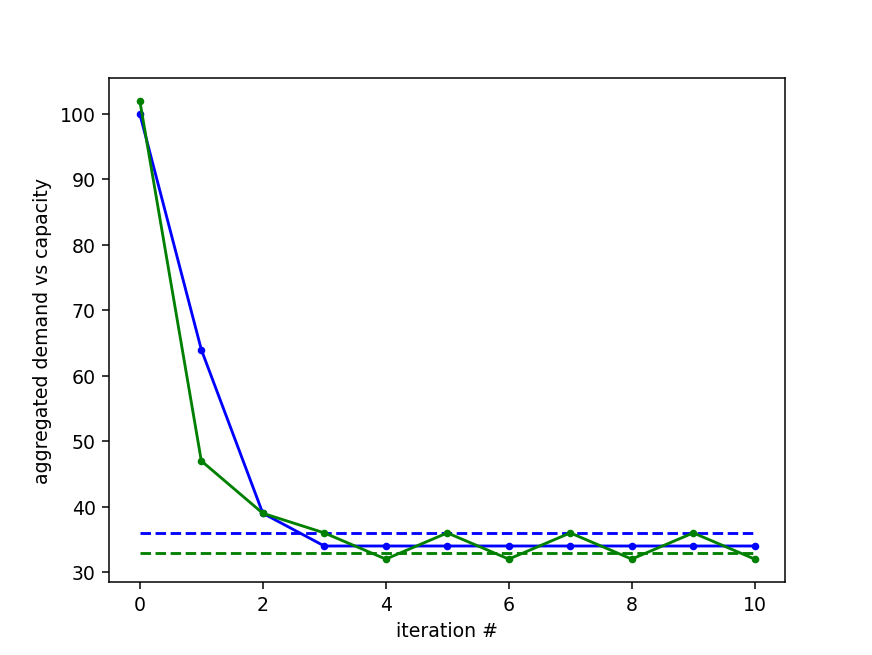

Text(0, 0.5, 'aggregated demand vs capacity')

In [14]:
fig = plt.figure()
ax = fig.add_subplot(111)

refs = np.array([problem.C_j for _ in range(len(logger.x_k_iterates))])
actuals = np.array([sum(x_k[:, 1:]) for x_k in logger.x_k_iterates])

plt.plot(refs[:, 0], 'b--')
plt.plot(actuals[:, 0], 'b.-')
plt.plot(refs[:, 1], 'g--')
plt.plot(actuals[:, 1], 'g.-')

ax.set_xlabel('iteration #')
ax.set_ylabel('aggregated demand vs capacity')